## AutoEncoders on PointClouds - Modular Code

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.fc_ae import FullyConnectedAutoEncoder
from tf_lab.point_clouds.fc_ae import Configuration as FC_Conf

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_ae import Configuration as PN_Conf

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.in_out import train_validate_test_split
from tf_lab.point_clouds.in_out import load_crude_point_clouds

from general_tools.in_out import create_dir
from geo_tool import Point_Cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
DATA_PATH = '/Users/optas/DATA/Point_Clouds/Shape_Net_Core/from_manifold_meshes/1024/03001627'
file_names = pio.load_filenames_of_input_data(DATA_PATH)
file_names = file_names[:500]
all_pclouds, model_names = load_crude_point_clouds(file_names=file_names, n_threads=11)

6778 files containing  point clouds were found.


In [4]:
train_data, val_data, test_data = train_validate_test_split(all_pclouds, train_perc=0.8, 
                                                            validate_perc=0.1, test_perc=0.1, seed=seed)

train_data = PointCloudDataSet(train_data)
val_data = PointCloudDataSet(val_data)
test_data = PointCloudDataSet(test_data)

# # train_data = PointCloudDataSet(train_data, noise={'frac':0.50, 'filler':0.0})
# # val_data = PointCloudDataSet(val_data, noise={'frac':0.50, 'filler':0.0})
# # test_data = PointCloudDataSet(test_data, noise={'frac':0.50, 'filler':0.0})

In [5]:
tf.reset_default_graph()

training_epochs = 200
batch_size = 20
saver_step = 20
train_dir = '/Users/optas/Desktop/yousoulin'

# n_input = 1024 * 3

# conf = FC_Conf(n_input, training_epochs, batch_size=batch_size, \
#                      saver_step=saver_step, train_dir=train_dir, loss_display_step=5)

# ae = FullyConnectedAutoEncoder('fc1', conf)

n_input = [1024, 3]
conf = PN_Conf(n_input, training_epochs, batch_size=batch_size, \
                     saver_step=saver_step, gauss_augment={'mu': 0.0, 'sigma': 0.02}, train_dir=train_dir, loss_display_step=1)

ae = PointNetAutoEncoder('ae', conf)

In [7]:
ae.train(train_data, conf)

KeyboardInterrupt: 

In [21]:
tf.reset_default_graph()

training_epochs = 200
batch_size = 20
saver_step = 20
train_dir = '/Users/optas/Desktop/lala'

n_input = 1024 * 3
conf = FC_Conf(n_input, training_epochs, batch_size=batch_size, \
                     saver_step=saver_step, train_dir=train_dir, loss_display_step=5)
ae = FullyConnectedAutoEncoder('fc1', conf)

ae.restore_model(conf.train_dir, 181)



In [ ]:
#     net = dnn(X)
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, Y))
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
#     accuracy = tf.reduce_mean(
#         tf.cast(tf.equal(tf.argmax(net, 1), tf.argmax(Y, 1)), tf.float32),
#         name='acc')

#     # Using TFLearn Trainer
#     # Define a training op (op for backprop, only need 1 in this model)
#     trainop = tflearn.TrainOp(loss=loss, optimizer=optimizer,
#                               metric=accuracy, batch_size=128)

#     # Create Trainer, providing all training ops. Tensorboard logs stored
#     # in /tmp/tflearn_logs/. It is possible to change verbose level for more
#     # details logs about gradients, variables etc...
#     trainer = tflearn.Trainer(train_ops=trainop, tensorboard_verbose=0)
#     # Training for 10 epochs.
#     trainer.fit({X: trainX, Y: trainY}, val_feed_dicts={X: testX, Y: testY},
#                 n_epoch=10, show_metric=True)

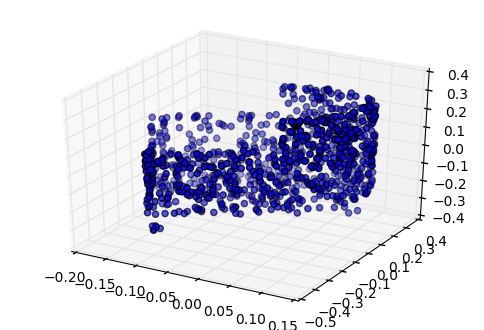

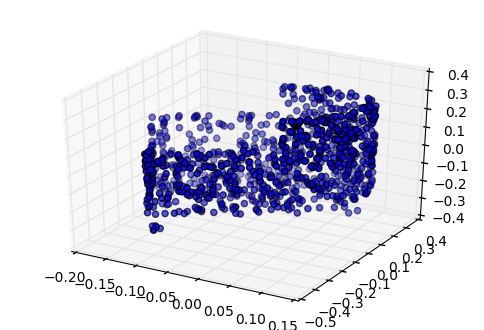

In [47]:
from general_tools.rla.three_d_transforms import rand_rotation_matrix

batch_i, _, _ = train_data.next_batch(batch_size)
batch_i = batch_i.reshape([batch_size] + conf.n_input)

r_rotation = rand_rotation_matrix()
r_rotation[0, 2] = 0
r_rotation[2, 0] = 0
r_rotation[1, 2] = 0
r_rotation[2, 1] = 0
r_rotation[2, 2] = 1

batch_i = batch_i.dot(r_rotation)
j = 2
Point_Cloud(points=batch_i[j]).plot()




# batch_i = batch_i.reshape([batch_size] + conf.n_input)

# x_sample, _, _ =  train_data.next_batch(conf.batch_size)
# x_reconstruct, cost = ae.reconstruct(x_sample)
# print cost

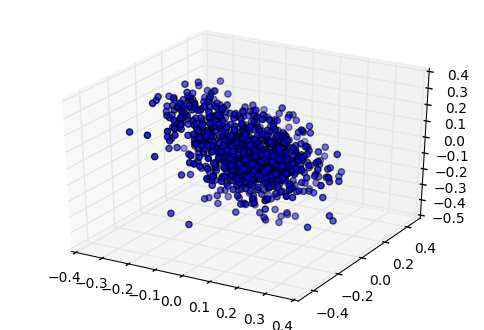

In [25]:
pclouds_samples = 1024
i = 3
Point_Cloud(points=x_reconstruct[i].reshape(pclouds_samples, 3)).plot();

# epoch = 100
# fc_ae.restore_model(osp.join(train_dir, 'model.ckpt-' + str(epoch)))


# # # saver.restore(self.session, (model_path + '-' + str(step)) if step!=None else model_path)



In [ ]:
from sklearn.cluster import KMeans
point_clouds
 sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')[source]
K-Means clustering

